<h1 style="font-size:30px;">Training the ASL Classifier using VGG-16 (Transfer Learning + Fine Tuning)</h1>  

In this notebook, we implement a hybrid approach to **transfer learning** where we use pre-trained weights for the first layers of the feature extractor, and train the weights for the last layers of the feature extractor, as well as the full connected layers of the classifer. This approach is called **fine-tuning** because it makes small adjustments to the more abstract representations of the model being reused to make them more relevant for the problem at hand.

**The fine-tuning technique is summarized below:**

1. Instantiate the VGG-16 convolutional base with pre-trained weights from ImageNet
2. Configure the convolutional base as "trainable"
3. Freeze all the layers in the convolutional base (EXCEPT the last four)
4. Add our custom classifier layer for the ASL dataset
5. Train the model (the last four layers of the feature extractor, plus the classifier)

<img src='https://github.com/AlbertaBeef/asl_tutorial/raw/2022.2/images/VGG16_06_asl_fine_tuning.png' width=1000 align='center'><br/>

## Table of Contents
* [1 System Configuration](#1-System-Configuration)
* [2 Download and Extract the Dataset](#2-Download-and-Extract-the-Dataset)
* [3 Dataset and Training Configuration](#3-Dataset-and-Training-Configuration)
* [4 Training the Model with Fine-Tuning](#4-Training-the-Model-with-Fine-Tuning)
* [5 Model Evaluation](#5-Model-Evaluation)
* [6 Conclusion](#6-Conclusion)

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import random
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
import zipfile
import requests
import glob as glob

from tensorflow.keras.utils import image_dataset_from_directory

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter)
from dataclasses import dataclass 

block_plot = False
plt.rcParams['figure.figsize'] = (12, 9)
SEED_VALUE = 42 

2023-04-21 15:15:32.282833: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-21 15:15:32.412765: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
print("tensorflow version : ",tf.__version__)
print("tensorflow version : ",keras.__version__)
print("opencv version : ",cv2.__version__)

tensorflow version :  2.10.0
tensorflow version :  2.10.0
opencv version :  4.6.0


## 1 System Configuration

In [3]:
def system_config():
    
    # Get list of GPUs.
    gpu_devices = tf.config.list_physical_devices('GPU')
    print(gpu_devices)
    
    if len(gpu_devices) > 0:
        print('Using GPU')
        os.environ["CUDA_VISIBLE_DEVICES"] = '0'
        os.environ['TF_CUDNN_DETERMINISTIC'] = '1' 
        
        # If there are any gpu devices, use first gpu.
        tf.config.experimental.set_visible_devices(gpu_devices[0], 'GPU')
        
        # Grow the memory usage as it is needed by the process.
        tf.config.experimental.set_memory_growth(gpu_devices[0], True)
        
        # Enable using cudNN.
        os.environ['TF_USE_CUDNN'] = "true"
    else:
        print('Using CPU')

system_config()

[]
Using CPU


## 2 Download and Extract the Dataset

In [3]:
def download_file(url, save_name):
    url = url
    file = requests.get(url)

    open(save_name, 'wb').write(file.content)

In [4]:
def unzip(zip_file=None):
    try:
        with zipfile.ZipFile(zip_file) as z:
            z.extractall("./")
            print("Extracted all")
    except:
        print("Invalid file")

In [5]:
#download_file(
#    'https://www.site.com/.../dataset_ASL_reduced.zip?dl=1', 
#    'dataset_ASL_reduced.zip'
#)
#    
#unzip(zip_file='dataset_ASL_reduced.zip')

In [6]:
dataset_path = '../input/asl-alphabet/asl_alphabet_train/asl_alphabet_train'
reduced_dataset_path = './dataset_ASL_reduced'

# Class names.
class_names = sorted([f for f in os.listdir(dataset_path) if not f.startswith('.')])

In [7]:
import os, shutil

if os.path.exists(reduced_dataset_path):
    shutil.rmtree(reduced_dataset_path) 
os.mkdir(reduced_dataset_path)
        
for i in range(len(class_names)):
    
    image_paths = glob.glob(f"{dataset_path}/{class_names[i]}/*", recursive=True)

    random_idx = random.choice(list(range(0, len(image_paths))))
    image = plt.imread(image_paths[random_idx])
    
    dst_path = reduced_dataset_path + '/' + class_names[i]
    os.mkdir(dst_path)
    
    for j in range(200):
        src_path = image_paths[j]
        #image_filename = os.path.basename(src_path)
        shutil.copy(src_path,dst_path)

## 3 Dataset and Training Configuration

In [4]:
@dataclass(frozen=True)
class DatasetConfig:
    NUM_CLASSES: int = 29
    IMG_HEIGHT:  int = 224
    IMG_WIDTH:   int = 224
    CHANNELS:    int = 3
    BATCH_SIZE:  int = 32
    DATA_ROOT:   str = './dataset_ASL_reduced'
        
@dataclass(frozen=True)
class TrainingConfig:
    BATCH_SIZE:     int   = 32
    EPOCHS:         int   = 51
    LEARNING_RATE:  float = 0.0001
    CHECKPOINT_DIR: str   = './saved_models_asl_classifier3'

## 4 Training the Model with Fine-Tuning

The Keras API provides the following utility that is used to instantiate a VGG-16 model, which can be initialized with either pre-trained weights from ImageNet or random initial weights. **In this notebook, we will load the model with weights from the ImageNet dataset** as a starting point for **Fine-Tuning.** For more information on the VGG-16 model available in Keras, refer to the: <a href="https://www.tensorflow.org/api_docs/python/tf/keras/applications/vgg16/VGG16" target="_blank">Keras VGG-16 Model API</a>

```python
tf.keras.applications.vgg16.VGG16(include_top=True, 
                                  weights='imagenet', 
                                  input_tensor=None,
                                  input_shape=None, 
                                  pooling=None, 
                                  classes=1000,
                                  classifier_activation='softmax',
                                 )
```

<img src='https://github.com/AlbertaBeef/asl_tutorial/raw/2022.2/images/VGG16_01_imagenet.png' width=1000 align='center'><br/>


In [5]:
print('Create an VGG16 model along with the imagenet pre-trained weights.')
input_shape = (DatasetConfig.IMG_HEIGHT, DatasetConfig.IMG_WIDTH, DatasetConfig.CHANNELS)
vgg16_model = tf.keras.applications.vgg16.VGG16(input_shape=input_shape,
                                                include_top=True,
                                                weights='imagenet',
                                               )

Create an VGG16 model along with the imagenet pre-trained weights.


2023-04-21 15:15:55.864417: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


553467096/553467096 [==============================] - 19s 0us/step


In [6]:
print(vgg16_model.summary())

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     



### 4.1 VGG Convolutional Base
We begin by creating a model of the VGG-16 convolutional base. We can do this by instantiating the model and setting `include_top = False`, which excludes the fully connected layers. In this notebook, we will instantiate the model with weights that were learned by training the model on the ImageNet dataset.

<img src='https://github.com/AlbertaBeef/asl_tutorial/raw/2022.2/images/VGG16_10_pretrained_base.png' width=1000 align='center'><br/>


In [7]:
print('Create an VGG16 model along with the imagenet pre-trained weights.')
input_shape = (DatasetConfig.IMG_HEIGHT, DatasetConfig.IMG_WIDTH, DatasetConfig.CHANNELS)
vgg16_model_base = tf.keras.applications.vgg16.VGG16(input_shape=input_shape,
                                                    include_top=False,
                                                    weights='imagenet',
                                                   )


Create an VGG16 model along with the imagenet pre-trained weights.
58889256/58889256 [==============================] - 2s 0us/step


In [8]:
print(vgg16_model_base.summary())

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

### 4.2 Freeze all but the Last Four Layers for Fine-Tuning

In the previous section, we set the `trainable` attribute of the convolutional base to `True`. This now allows us to "freeze" a selected number of layers in the convolutional base so that only the last few layers in the convolutional base are trainable. 

<img src='https://github.com/AlbertaBeef/asl_tutorial/raw/2022.2/images/VGG16_11_freeze_layers.png' width=1000 align='center'><br/>

#### How to freeze only a few layers?
There are two ways to specify which layers in the model are trainable (tunable). 
1. We can start by making the entire convolutional base trainable by setting the `trainable` flag to `True`. Then loop over the **initial** layers and make them untrainable by setting the same (`trainable`) flag for each layer to `False`. 

2. We can freeze the entire convolutional base by setting the `trainable` flag to `False`, and then loop over the  **last** few layers and set the `trainable` flag to `True`.

We use the first approach in this notebook. In the code cell below, we start by setting the entire convolutional base as "trainable" by settng the `trainable` attribute to `True`.

In [9]:
# First make the convolutional base trainable.
vgg16_model_base.trainable = True
print('All weights trainable, fine tuning ...')

print('Freeze the weights of the layers that we are not training')
for layer in vgg16_model_base.layers[:-4]:
    layer.trainable = False

All weights trainable, fine tuning ...
Freeze the weights of the layers that we are not training


In [10]:
print(vgg16_model_base.summary())

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

### 4.3 Add the Classification Layer
Since we intend to train and use the model to classify hand signals from the ASL dataset (which has 29 classes), we will need to add our own classification layer. In this example, we have chosen to use just a single fully connected dense layer that contains 256 nodes, followed by a softmax output layer that contains 29 nodes for each of the 29 classes. The number of dense layers and the number of nodes per layer is a design choice, but the number of nodes in the output layer must match the number of classes in the dataset.

<img src='https://github.com/AlbertaBeef/asl_tutorial/raw/2022.2/images/VGG16_12_add_classifier.png' width=1000 align='center'><br/>

In [11]:
print('Add Classification Layers (output or top)')
# Take the output of the VGG16 just before last layer
x = vgg16_model_base.layers[-1].output

# reduce the size of the last layer (7x7x512=25088)
# to account for conv2d/dense limitations in Vitis-AI
x = tf.keras.layers.MaxPooling2D()(x)
    
# Flatten the outputs of the last conv layer
flatten = tf.keras.layers.Flatten(name='flatten')(x)

# Fully Connected layers.
dense = tf.keras.layers.Dense(256, activation= 'relu',name='fc')(flatten)

# adding the prediction layer with 'softmax'
predictions = tf.keras.layers.Dense(DatasetConfig.NUM_CLASSES, activation='softmax',name='predictions')(dense)
    
# Create the new model with the new outputs
model = tf.keras.Model(inputs=vgg16_model_base.input, outputs=predictions)


Add Classification Layers (output or top)


In [12]:
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

### 4.4 Prepare the Training and Validation Dataset

In [13]:
train_dataset = image_dataset_from_directory(directory=DatasetConfig.DATA_ROOT,
                                             batch_size=TrainingConfig.BATCH_SIZE,
                                             shuffle=True,
                                             seed=SEED_VALUE,
                                             label_mode='categorical',
                                             image_size=(DatasetConfig.IMG_WIDTH, DatasetConfig.IMG_HEIGHT),
                                             subset='training',
                                             validation_split=0.2
                                            )

valid_dataset = image_dataset_from_directory(directory=DatasetConfig.DATA_ROOT,
                                             batch_size=TrainingConfig.BATCH_SIZE,
                                             shuffle=True,
                                             seed=SEED_VALUE,
                                             label_mode='categorical',
                                             image_size=(DatasetConfig.IMG_WIDTH, DatasetConfig.IMG_HEIGHT),
                                             subset='validation',
                                             validation_split=0.2
                                            )

Found 5800 files belonging to 29 classes.
Using 4640 files for training.
Found 5800 files belonging to 29 classes.
Using 1160 files for validation.


### 4.5 Display Sample Images

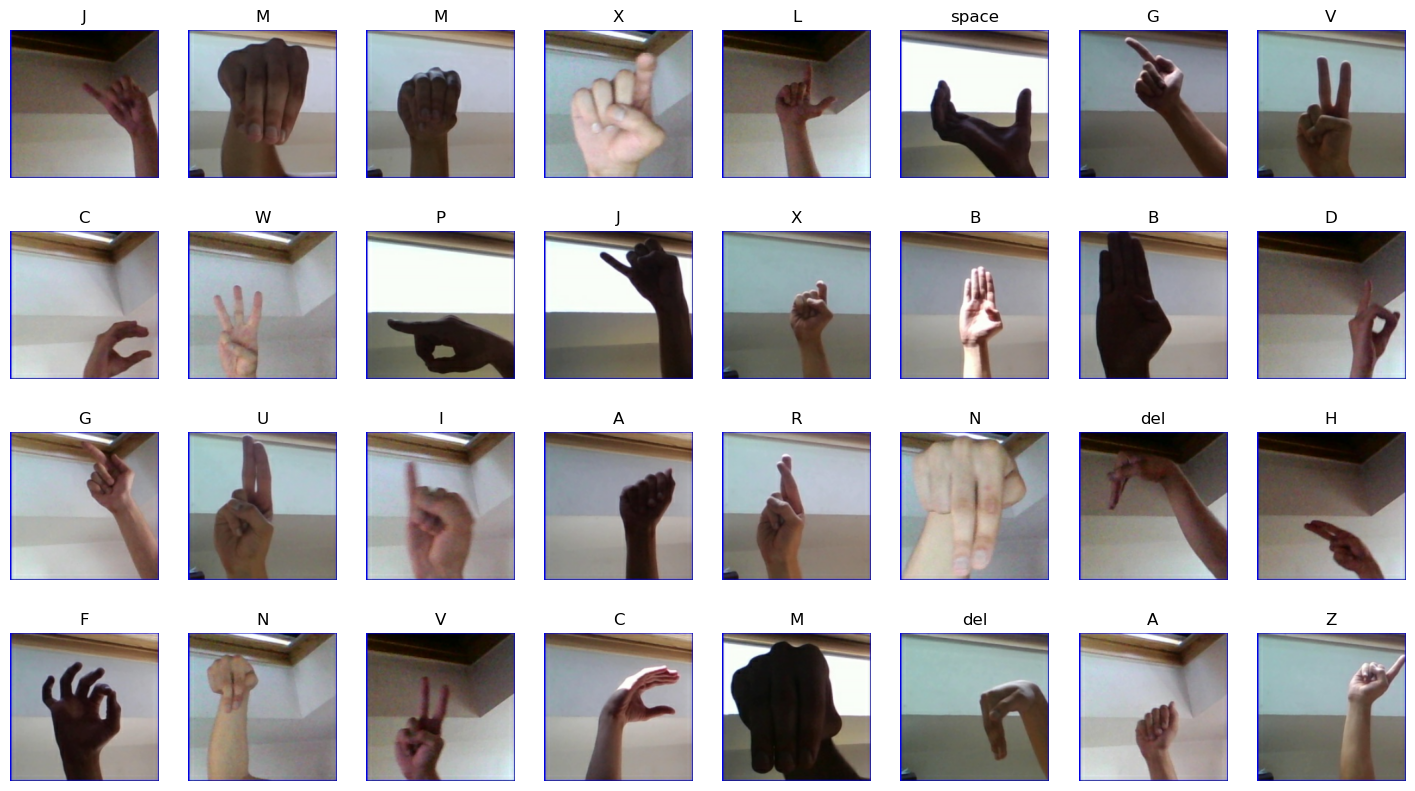

In [14]:
class_names = train_dataset.class_names

plt.figure(figsize=(18, 10))

# Assumes dataset batch_size is at least 32.
num_rows = 4
num_cols = 8

# Here we use the take() method to retrieve just the first batch of data from the training portion of the dataset.
for image_batch, labels_batch in train_dataset.take(1): 
    
    # For the batch of images and the associated (one-hot encoded) labels, 
    # plot each of the images in the batch and the associated ground truth labels.
    for i in range(num_rows*num_cols):
        ax = plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        truth_idx = np.nonzero(labels_batch[i].numpy())
        plt.title(class_names[truth_idx[0][0]])
        plt.axis("off")

### 4.6 Compile and Train the Model

<img src='https://github.com/AlbertaBeef/asl_tutorial/raw/2022.2/images/VGG16_06_asl_fine_tuning.png' width=1000 align='center'><br/>

In [15]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=TrainingConfig.LEARNING_RATE),
                    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                    metrics=['accuracy'],
                   )

In [16]:
# Save best model based on highest validation_accuracy.
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=TrainingConfig.CHECKPOINT_DIR,
                                                               save_weights_only=False,
                                                               monitor='val_accuracy',
                                                               mode='max',
                                                               save_best_only=True,
                                                              )

In [17]:
print(f"Model evaluation accuracy: {model.evaluate(valid_dataset)[1]*100.:.3f}")

37/37 [==============================] - 68s 2s/step - loss: 32.0957 - accuracy: 0.0328
Model evaluation accuracy: 3.276


In [18]:
from datetime import datetime

# datetime object containing current date and time
timestamp1 = datetime.now()
print(timestamp1)

2023-04-21 15:19:23.025416


In [19]:
# Train the Model.
training_results = model.fit(train_dataset,
                                   validation_data=valid_dataset,
                                   epochs=TrainingConfig.EPOCHS,
                                   workers=4,
                                   use_multiprocessing=True, 
                                   callbacks=model_checkpoint_callback,
                                  )

Epoch 1/51
145/145 [==============================] - ETA: 0s - loss: 3.5950 - accuracy: 0.1435

INFO:tensorflow:Assets written to: ./saved_models_asl_classifier3/assets


INFO:tensorflow:Assets written to: ./saved_models_asl_classifier3/assets


145/145 [==============================] - 361s 2s/step - loss: 3.5950 - accuracy: 0.1435 - val_loss: 2.4631 - val_accuracy: 0.3017
Epoch 2/51
145/145 [==============================] - ETA: 0s - loss: 1.5844 - accuracy: 0.5293

INFO:tensorflow:Assets written to: ./saved_models_asl_classifier3/assets


INFO:tensorflow:Assets written to: ./saved_models_asl_classifier3/assets


145/145 [==============================] - 358s 2s/step - loss: 1.5844 - accuracy: 0.5293 - val_loss: 0.6997 - val_accuracy: 0.7750
Epoch 3/51
145/145 [==============================] - ETA: 0s - loss: 0.3798 - accuracy: 0.8804

INFO:tensorflow:Assets written to: ./saved_models_asl_classifier3/assets


INFO:tensorflow:Assets written to: ./saved_models_asl_classifier3/assets


145/145 [==============================] - 360s 2s/step - loss: 0.3798 - accuracy: 0.8804 - val_loss: 0.2904 - val_accuracy: 0.9095
Epoch 4/51
145/145 [==============================] - ETA: 0s - loss: 0.0971 - accuracy: 0.9694

INFO:tensorflow:Assets written to: ./saved_models_asl_classifier3/assets


INFO:tensorflow:Assets written to: ./saved_models_asl_classifier3/assets


145/145 [==============================] - 365s 3s/step - loss: 0.0971 - accuracy: 0.9694 - val_loss: 0.1368 - val_accuracy: 0.9569
Epoch 5/51
145/145 [==============================] - ETA: 0s - loss: 0.0258 - accuracy: 0.9931

INFO:tensorflow:Assets written to: ./saved_models_asl_classifier3/assets


INFO:tensorflow:Assets written to: ./saved_models_asl_classifier3/assets


145/145 [==============================] - 361s 2s/step - loss: 0.0258 - accuracy: 0.9931 - val_loss: 0.0942 - val_accuracy: 0.9784
Epoch 6/51
145/145 [==============================] - 361s 2s/step - loss: 0.0180 - accuracy: 0.9955 - val_loss: 0.0880 - val_accuracy: 0.9784
Epoch 7/51
145/145 [==============================] - 363s 3s/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.0849 - val_accuracy: 0.9784
Epoch 8/51
145/145 [==============================] - ETA: 0s - loss: 6.1940e-04 - accuracy: 1.0000

INFO:tensorflow:Assets written to: ./saved_models_asl_classifier3/assets


INFO:tensorflow:Assets written to: ./saved_models_asl_classifier3/assets


145/145 [==============================] - 367s 3s/step - loss: 6.1940e-04 - accuracy: 1.0000 - val_loss: 0.0873 - val_accuracy: 0.9802
Epoch 9/51
145/145 [==============================] - 361s 2s/step - loss: 4.1813e-04 - accuracy: 1.0000 - val_loss: 0.0883 - val_accuracy: 0.9802
Epoch 10/51
145/145 [==============================] - 362s 2s/step - loss: 3.1310e-04 - accuracy: 1.0000 - val_loss: 0.0889 - val_accuracy: 0.9802
Epoch 11/51
145/145 [==============================] - 362s 2s/step - loss: 2.4580e-04 - accuracy: 1.0000 - val_loss: 0.0900 - val_accuracy: 0.9802
Epoch 12/51
145/145 [==============================] - ETA: 0s - loss: 1.9960e-04 - accuracy: 1.0000

INFO:tensorflow:Assets written to: ./saved_models_asl_classifier3/assets


INFO:tensorflow:Assets written to: ./saved_models_asl_classifier3/assets


145/145 [==============================] - 364s 3s/step - loss: 1.9960e-04 - accuracy: 1.0000 - val_loss: 0.0908 - val_accuracy: 0.9810
Epoch 13/51
145/145 [==============================] - ETA: 0s - loss: 1.6463e-04 - accuracy: 1.0000

INFO:tensorflow:Assets written to: ./saved_models_asl_classifier3/assets


INFO:tensorflow:Assets written to: ./saved_models_asl_classifier3/assets


145/145 [==============================] - 365s 3s/step - loss: 1.6463e-04 - accuracy: 1.0000 - val_loss: 0.0913 - val_accuracy: 0.9819
Epoch 14/51
145/145 [==============================] - 360s 2s/step - loss: 1.3936e-04 - accuracy: 1.0000 - val_loss: 0.0921 - val_accuracy: 0.9819
Epoch 15/51
145/145 [==============================] - 357s 2s/step - loss: 1.1847e-04 - accuracy: 1.0000 - val_loss: 0.0922 - val_accuracy: 0.9819
Epoch 16/51
145/145 [==============================] - 359s 2s/step - loss: 1.0204e-04 - accuracy: 1.0000 - val_loss: 0.0927 - val_accuracy: 0.9810
Epoch 17/51
145/145 [==============================] - 358s 2s/step - loss: 8.7937e-05 - accuracy: 1.0000 - val_loss: 0.0930 - val_accuracy: 0.9819
Epoch 18/51
145/145 [==============================] - 362s 2s/step - loss: 7.7023e-05 - accuracy: 1.0000 - val_loss: 0.0932 - val_accuracy: 0.9810
Epoch 19/51
145/145 [==============================] - 357s 2s/step - loss: 6.7544e-05 - accuracy: 1.0000 - val_loss: 0.0935

INFO:tensorflow:Assets written to: ./saved_models_asl_classifier3/assets


INFO:tensorflow:Assets written to: ./saved_models_asl_classifier3/assets


145/145 [==============================] - 365s 3s/step - loss: 3.9852e-06 - accuracy: 1.0000 - val_loss: 0.1026 - val_accuracy: 0.9828
Epoch 48/51
145/145 [==============================] - 360s 2s/step - loss: 3.6325e-06 - accuracy: 1.0000 - val_loss: 0.1026 - val_accuracy: 0.9828
Epoch 49/51
145/145 [==============================] - 362s 2s/step - loss: 3.3235e-06 - accuracy: 1.0000 - val_loss: 0.1031 - val_accuracy: 0.9819
Epoch 50/51
145/145 [==============================] - 358s 2s/step - loss: 3.0327e-06 - accuracy: 1.0000 - val_loss: 0.1034 - val_accuracy: 0.9819
Epoch 51/51
145/145 [==============================] - 363s 3s/step - loss: 2.7705e-06 - accuracy: 1.0000 - val_loss: 0.1038 - val_accuracy: 0.9819


In [20]:
timestamp2 = datetime.now()
print(timestamp2)

print(timestamp2-timestamp1)

2023-04-21 20:25:34.030270
5:06:11.004854


### 4.7 Plot the Training Results

In [21]:
def plot_results(metrics, ylabel=None, ylim=None, metric_name=None, color=None):
    
    fig, ax = plt.subplots(figsize=(15, 4))

    if not (isinstance(metric_name, list) or isinstance(metric_name, tuple)):
        metrics = [metrics,]
        metric_name = [metric_name,]
        
    for idx, metric in enumerate(metrics):    
        ax.plot(metric, color=color[idx])
    
    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(ylabel)
    plt.xlim([0, TrainingConfig.EPOCHS-1])
    plt.ylim(ylim)
    # Tailor x-axis tick marks
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    plt.grid(True)
    plt.legend(metric_name)   
    plt.show(block=block_plot)
    plt.close()

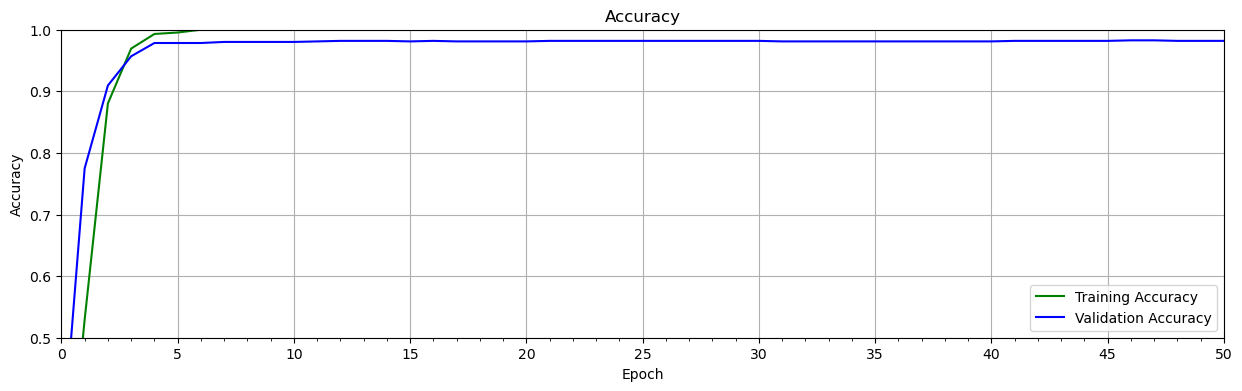

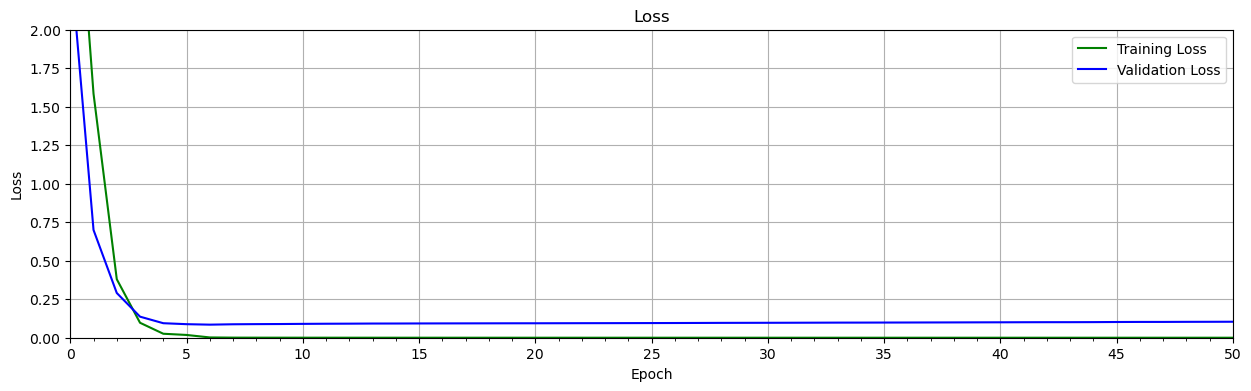

In [22]:
# Retrieve training results.
train_loss = training_results.history["loss"]
train_acc  = training_results.history["accuracy"]
valid_loss = training_results.history["val_loss"]
valid_acc  = training_results.history["val_accuracy"]
    
plot_results([ train_acc, valid_acc ], 
            ylabel="Accuracy",
            ylim = [0.5, 1.0],
            metric_name=["Training Accuracy", "Validation Accuracy"],
            color=["g", "b"])
 
max_loss = 2.0

plot_results([ train_loss, valid_loss ],        
            ylabel="Loss", 
            ylim = [0.0, max_loss],
            metric_name=["Training Loss", "Validation Loss"],
            color=["g", "b"]);

**Save model**

Once we are happy with the performance of the model, we can save it as a .h5 file, simply using the `save` method.

In [28]:
print(model.summary())
model.save('tf2_asl_classifier3.h5')


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

**Load model**

Load model for the rest of the tutorial with the `load_model` method.

In [29]:
model = keras.models.load_model('tf2_asl_classifier3.h5')

## 5 Model Evaluation

### 5.1 Evaluate Accuracy

In [30]:
# Load saved model.
# Final evaluation accuracy on the validation set.
model = tf.keras.models.load_model(TrainingConfig.CHECKPOINT_DIR)
print(f"Model evaluation accuracy: {model.evaluate(valid_dataset)[1]*100.:.3f}")

37/37 [==============================] - 79s 2s/step - loss: 0.1026 - accuracy: 0.9828
Model evaluation accuracy: 98.276


### 5.2 Display Confusion Matrix

In [35]:
!pip3 install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 kB 2.8 MB/s eta 0:00:00a 0:00:01


Generating Predictions...


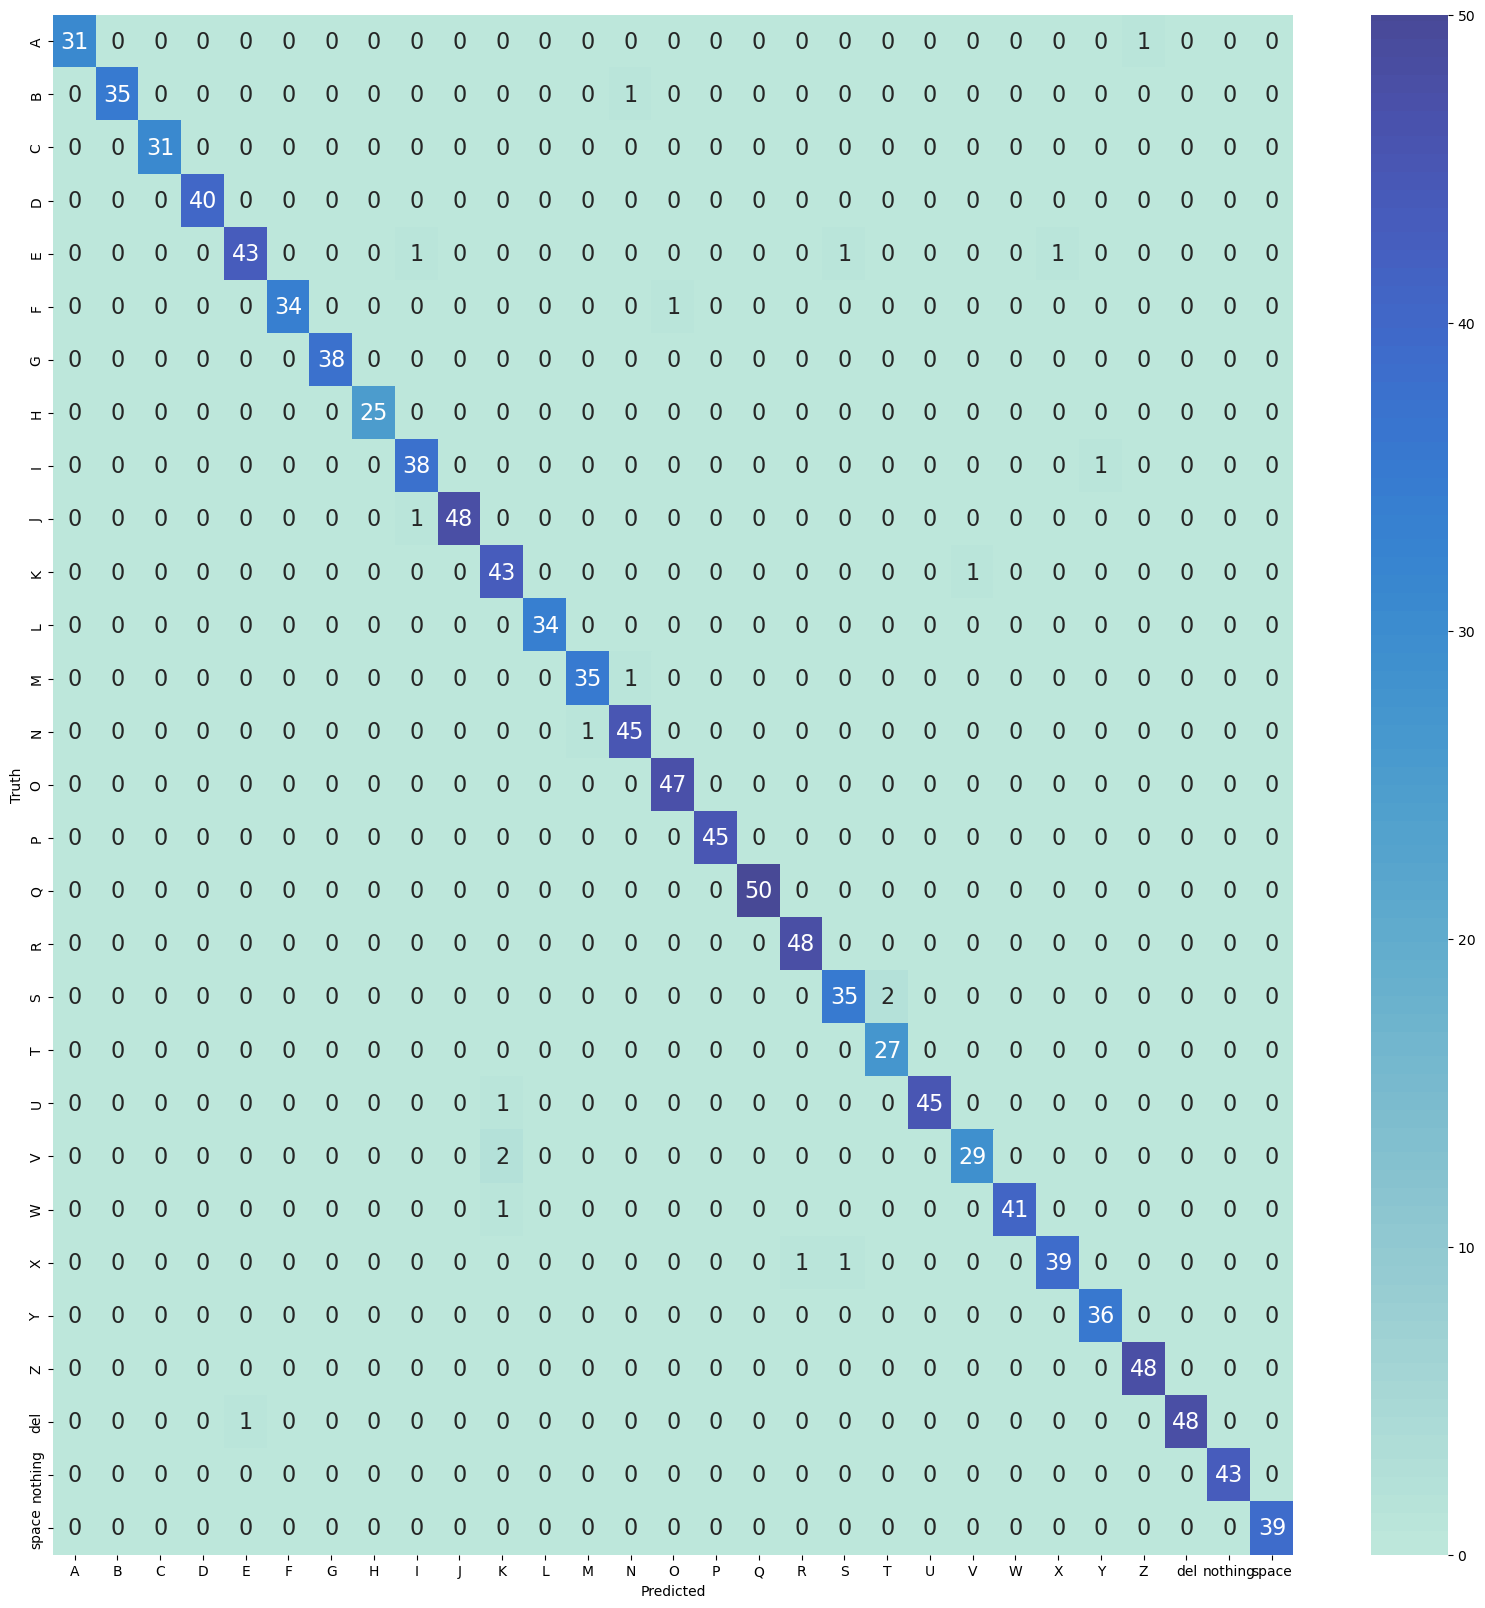

In [40]:
# reference : https://seaborn.pydata.org/generated/seaborn.heatmap.html
import seaborn as sn

class_names = valid_dataset.class_names

ground_truths = []
predictions = []

print("Generating Predictions...")
for data, target in valid_dataset:
    model_predictions = model.predict_on_batch(data)
    cls_predicted = np.argmax(model_predictions, axis=-1)
    cls_probs = np.max(model_predictions, axis=-1)

    predictions.extend(cls_predicted)
    
    cls_ground_truth = np.argmax(target, axis=-1)
    ground_truths.extend(cls_ground_truth)

confusion_matrix = tf.math.confusion_matrix(ground_truths, predictions)

plt.figure(figsize=[20, 20])
sn.heatmap(confusion_matrix, annot=True, fmt='d', annot_kws={"size": 16},center=80)
plt.xlabel('Predicted')
plt.ylabel('Truth')
ax = plt.gca()
ax.set_xticklabels(class_names)
ax.set_yticklabels(class_names)
plt.show()


### 5.3 Display Wrong Predictions

In [43]:
def display_wrong_predictions(dataset, checkpoint_dir=None, checkpoint_version=0):
    
    if not checkpoint_dir:
        checkpoint_dir = os.path.join(os.getcwd(), TrainingConfig.checkpoint_dir, f"version_{checkpoint_version}")
        
    # Load saved model.
    model = tf.keras.models.load_model(checkpoint_dir)
    
    plt.figure(figsize=(20, 15))
    num_rows = 4
    num_cols = 5
    class_names = dataset.class_names
    jdx = 0
    
    # Evaluate all the batches.
    for image_batch, labels_batch in dataset:
        
        # Predictions for the current batch.
        predictions = model.predict(image_batch)
        
        # Loop over all the images in the current batch.
        for idx in range(len(labels_batch)):
            
            pred_idx = tf.argmax(predictions[idx]).numpy()
            truth_idx = np.nonzero(labels_batch[idx].numpy())
            
            # Plot the images with incorrect predictions
            if pred_idx != truth_idx:
                
                jdx += 1
                
                if jdx > num_rows*num_cols:
                    # Break from the loops if the maximum number of images have been plotted
                    break
                
                ax = plt.subplot(num_rows, num_cols, jdx)
                title = str(class_names[truth_idx[0][0]]) + " : " + str(class_names[pred_idx])
                title_obj = plt.title(title)
                plt.setp(title_obj, color='r')
                plt.axis("off")
                plt.imshow(image_batch[idx].numpy().astype("uint8"))
    return  

1/1 [==============================] - 1s 771ms/step


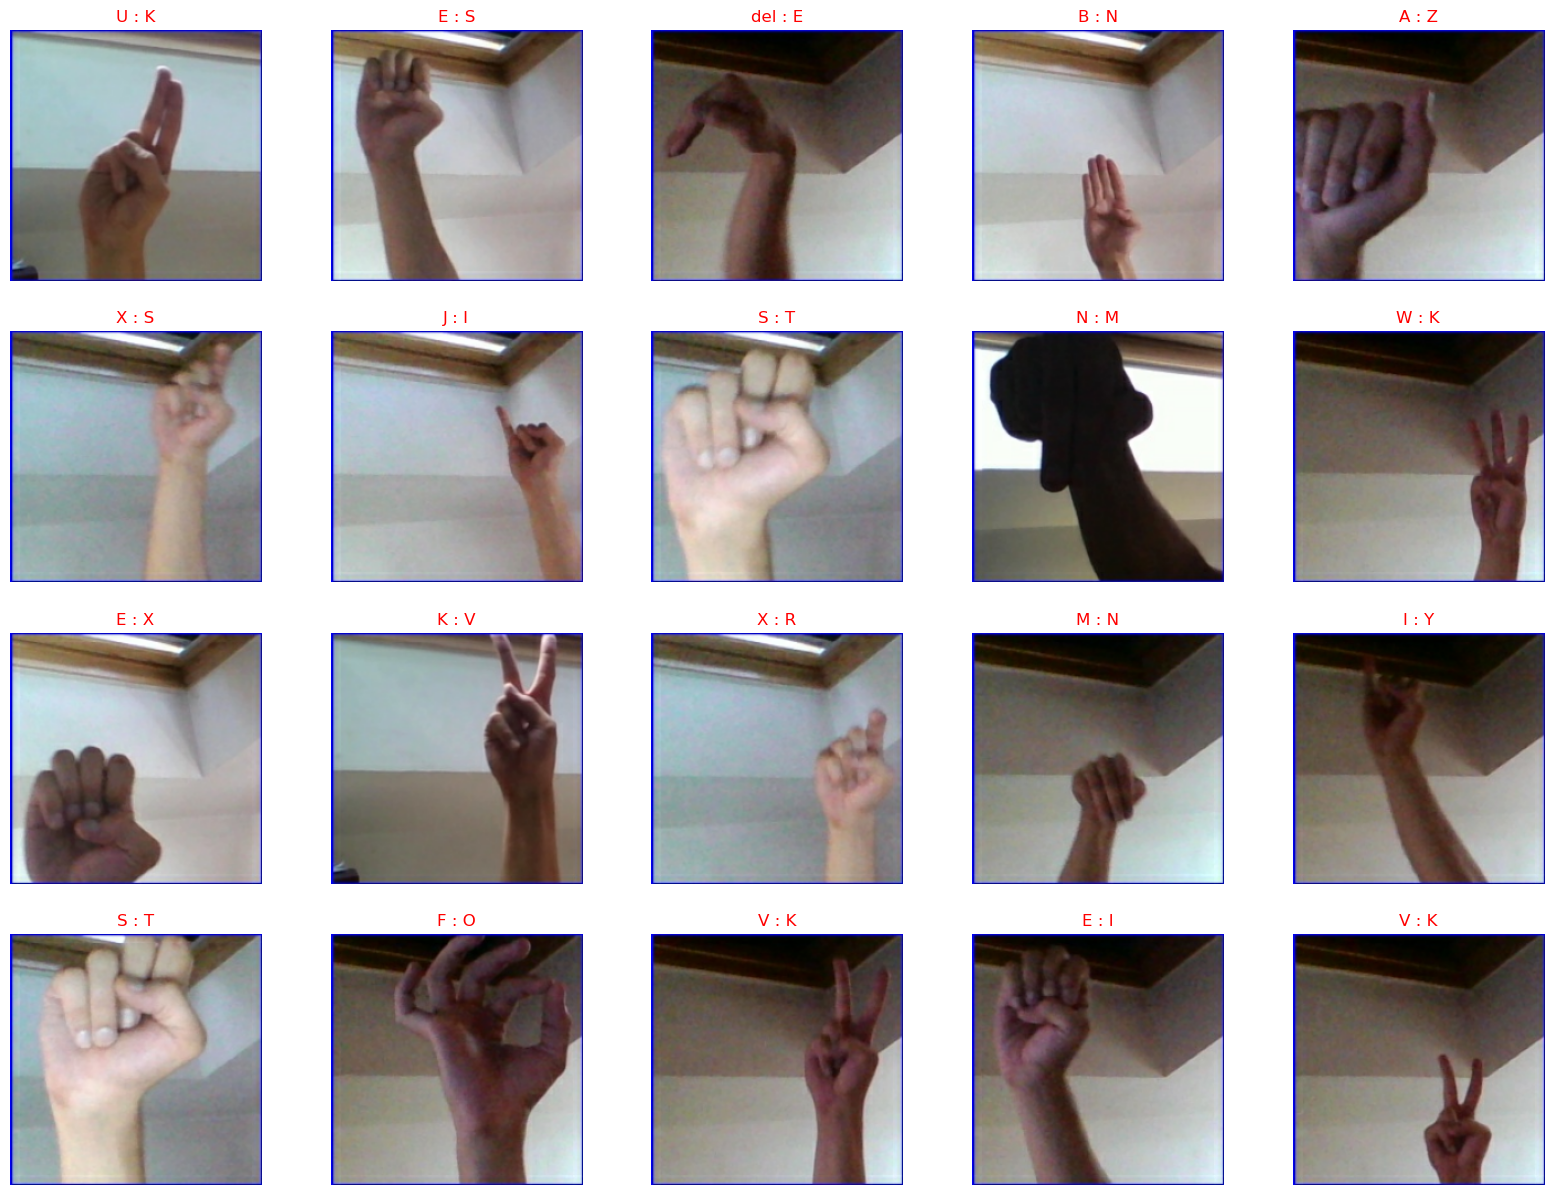

In [44]:
display_wrong_predictions(valid_dataset, TrainingConfig.CHECKPOINT_DIR)

## 6 Conclusion

In this notebook, we showed how you can use **fine-tuning** to make adjustments to the weights in the last few layers of a pre-trained convolutional base to improve the validation accuracy of the model. This is a very common technique that is used to leverage pre-existing models for new datasets. When using this approach, it is recommended that you first train the dense classifier only and then un-freeze the layers in the convolutional base that you wish to fine-tune and the model again (including the dense classifier) at a lower learning rate. 